# Test implementation rescaling

In [1]:
import numpy as np
from scipy.interpolate import interpolate
import os
import glob
from matplotlib import pyplot as plt
import xarray as xr
import xesmf as xe
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/utils"
os.chdir(path)
import dataset
import rescaling

In [2]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/HadGEM_driven_COSMO/Present/2003"
os.chdir(path)
filenames = dataset.getfiles()
print(filenames[0:24])

['lffd20030101000000.nc', 'lffd20030101010000.nc', 'lffd20030101020000.nc', 'lffd20030101030000.nc', 'lffd20030101040000.nc', 'lffd20030101050000.nc', 'lffd20030101060000.nc', 'lffd20030101070000.nc', 'lffd20030101080000.nc', 'lffd20030101090000.nc', 'lffd20030101100000.nc', 'lffd20030101110000.nc', 'lffd20030101120000.nc', 'lffd20030101130000.nc', 'lffd20030101140000.nc', 'lffd20030101150000.nc', 'lffd20030101160000.nc', 'lffd20030101170000.nc', 'lffd20030101180000.nc', 'lffd20030101190000.nc', 'lffd20030101200000.nc', 'lffd20030101210000.nc', 'lffd20030101220000.nc', 'lffd20030101230000.nc']


In [3]:
test_2km = dataset.new_dataset(filenames, 172, 173)
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/data"
os.chdir(path)
test_2km

<xarray.Dataset>
Dimensions:     (time: 24, rlon: 1542, rlat: 1542)
Coordinates:
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
    lon         (rlat, rlon) float32 -11.06 -11.04 -11.02 ... 34.27 34.31 34.34
    lat         (rlat, rlon) float32 29.61 29.61 29.62 29.62 ... 61.11 61.1 61.1
    height_2m   float32 2.0
    height_10m  float32 10.0
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.5 283.5
    RELHUM_2M   (time, rlat, rlon) float32 79.83 79.32 79.08 ... 79.15 79.35
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

In [4]:
test_2km = test_2km.drop('lon')
test_2km = test_2km.drop('lat')

## Downscaling

### xESMF

In [150]:
rand_week_12km = xr.open_dataset("random_week_12km.nc")
rand_week_12km = rand_week_12km.rename({'rlon': 'lon','rlat': 'lat'})
rand_week_12km = rand_week_12km.drop_vars('rotated_pole')

In [167]:
lon_b = ds_in["lon_b"].values[0]
lat_b = [ds_in["lat_b"].values[i][0]for i in range(1543)]
test_in = xr.Dataset(
    {
        "lon": (["lon"], np.arange(-18.86, 11.98, 0.02)),
        "lat": (["lat"], np.arange(-14.86, 15.98, 0.02)),
        "lon_b": (["lon_b"], lon_b),
        "lat_b": (["lat_b"], lat_b),
    }
)
test_in

<xarray.Dataset>
Dimensions:  (lon: 1542, lat: 1542, lon_b: 1543, lat_b: 1543)
Coordinates:
  * lon      (lon) float64 -18.86 -18.84 -18.82 -18.8 ... 11.9 11.92 11.94 11.96
  * lat      (lat) float64 -14.86 -14.84 -14.82 -14.8 ... 15.9 15.92 15.94 15.96
  * lon_b    (lon_b) float64 -18.86 -18.84 -18.82 -18.8 ... 11.94 11.96 11.98
  * lat_b    (lat_b) float64 -14.86 -14.84 -14.82 -14.8 ... 15.94 15.96 15.98
Data variables:
    *empty*

In [171]:
bilin_downs = xe.Regridder(test_out, test_in, method = 'bilinear')
bilin_downs

Overwrite existing file: bilinear_257x257_1542x1542.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_257x257_1542x1542.nc 
Reuse pre-computed weights? False 
Input grid shape:           (257, 257) 
Output grid shape:          (1542, 1542) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [172]:
bilin_2km = bilin_downs(test_ups)

using dimensions ('lat', 'lon') from data variable T_2M as the horizontal dimensions for this dataset.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/env/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


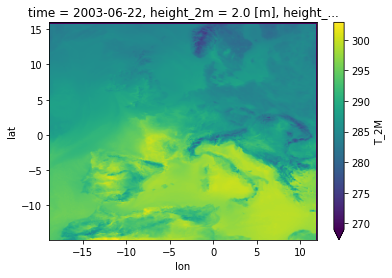

In [176]:
bilin_2km.T_2M.isel(time = 0).plot(vmin = 269)

It seems that only the bilinear downscaling can be made, which isn't enough

## interp2d

In [16]:
rlon = np.arange(-18.86, 11.9, 0.12)
rlat = np.arange(-14.86, 15.9, 0.12)

fun = interpolate.interp2d(rlon, rlat, ups_ds.T_2M.isel(time = 0), kind='linear') # kind could be {'linear', 'cubic', 'quintic'}
newlon = np.arange(-18.86, 11.98, 0.02)
newlat = np.arange(-14.86, 15.98, 0.02)
newvar = fun(newlon, newlat)
newvar

ValueError: Unsupported interpolation type 1, must be either of 'linear', 'cubic', 'quintic'.

In [13]:
xr.full_like(test, 0)

<xarray.Dataset>
Dimensions:     (rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
    time        datetime64[ns] 2003-06-22
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (rlat, rlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    RELHUM_2M   (rlat, rlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TOT_PR      (rlat, rlon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

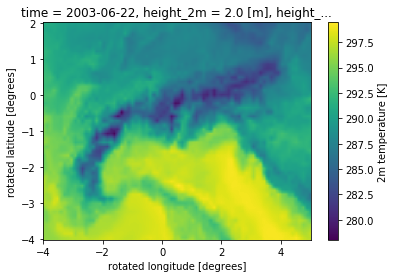

In [32]:
test = test_2km.isel(time = 0)
test.T_2M.values = newvar
test.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).plot()

## Upscaling

### xESMF

In [6]:
test_2km = test_2km.rename({'rlon': 'lon','rlat': 'lat'})

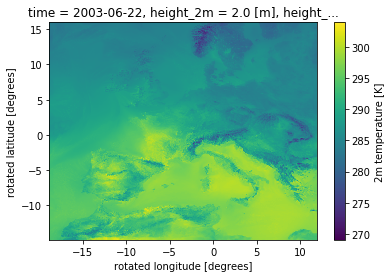

In [18]:
test_2km.T_2M.isel(time =0).plot()

In [164]:
lon_b = ds_out["lon_b"].values[0]
lat_b = [ds_out["lat_b"].values[i][0]for i in range(258)]
test_out = xr.Dataset(
    {
        "lon": (["lon"], np.arange(-18.86, 11.90, 0.12)),
        "lat": (["lat"], np.arange(-14.86, 15.90, 0.12)),
        "lon_b": (["lon_b"], lon_b),
        "lat_b": (["lat_b"], lat_b),
    }
)
test_out

<xarray.Dataset>
Dimensions:  (lon: 257, lat: 257, lon_b: 258, lat_b: 258)
Coordinates:
  * lon      (lon) float64 -18.86 -18.74 -18.62 -18.5 ... 11.5 11.62 11.74 11.86
  * lat      (lat) float64 -14.86 -14.74 -14.62 -14.5 ... 15.5 15.62 15.74 15.86
  * lon_b    (lon_b) float64 -18.86 -18.74 -18.62 -18.5 ... 11.74 11.86 11.98
  * lat_b    (lat_b) float64 -14.86 -14.74 -14.62 -14.5 ... 15.74 15.86 15.98
Data variables:
    *empty*

In [168]:
ups_grid = xe.Regridder(test_in, test_out, "conservative")

Overwrite existing file: conservative_1542x1542_257x257.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_1542x1542_257x257.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1542, 1542) 
Output grid shape:          (257, 257) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [169]:
test_ups = ups_grid(test_2km)

using dimensions ('lat', 'lon') from data variable T_2M as the horizontal dimensions for this dataset.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/env/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [170]:
test_ups

<xarray.Dataset>
Dimensions:     (time: 24, lat: 257, lon: 257)
Coordinates:
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
    height_2m   float32 2.0
    height_10m  float32 10.0
  * lon         (lon) float64 -18.86 -18.74 -18.62 -18.5 ... 11.62 11.74 11.86
  * lat         (lat) float64 -14.86 -14.74 -14.62 -14.5 ... 15.62 15.74 15.86
Data variables:
    T_2M        (time, lat, lon) float64 293.9 293.8 293.9 ... 283.4 283.5 283.8
    RELHUM_2M   (time, lat, lon) float64 79.63 81.79 83.16 ... 79.06 78.72 78.44
    TOT_PR      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

xESMF works for conservative upscaling, and seems to be the only function to offer conservative remapping (and the function that I didn't kept)

# Test

In [6]:
ingrid = rescaling.create_grid(-18.86, 11.98, 0.02, -14.86, 15.98, 0.02)
outgrid = rescaling.create_grid(-18.86, 11.9, 0.12, -14.86, 15.9, 0.12)

In [7]:
ups_ds = rescaling.upscale(test_2km, ingrid, outgrid)

Overwrite existing file: conservative_1542x1542_257x257.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('rlat', 'rlon') from data variable T_2M as the horizontal dimensions for this dataset.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/env/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [8]:
ups_ds

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 257, rlon: 257)
Coordinates:
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
    height_2m   float32 2.0
    height_10m  float32 10.0
  * rlon        (rlon) float64 -18.86 -18.74 -18.62 -18.5 ... 11.62 11.74 11.86
  * rlat        (rlat) float64 -14.86 -14.74 -14.62 -14.5 ... 15.62 15.74 15.86
Data variables:
    T_2M        (time, rlat, rlon) float64 293.9 293.8 293.9 ... 283.5 283.8
    RELHUM_2M   (time, rlat, rlon) float64 79.63 81.79 83.16 ... 78.72 78.44
    TOT_PR      (time, rlat, rlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

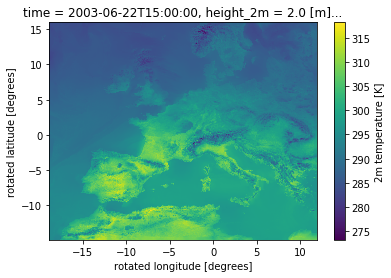

In [9]:
test_2km.T_2M.isel(time = 15).plot()

In [20]:
bilin_2km = xr.full_like(test_2km, 0)
rescaling.downscale(ups_ds, bilin_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'linear')

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.8 283.8
    RELHUM_2M   (time, rlat, rlon) float32 83.6 83.49 83.38 ... 0.0 0.0 0.0
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

In [11]:
lat_bnd = [-4, 2]
lon_bnd = [-4, 5]
bil_2km

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.8 283.8
    RELHUM_2M   (time, rlat, rlon) float32 83.6 83.49 83.38 ... 0.0 0.0 0.0
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

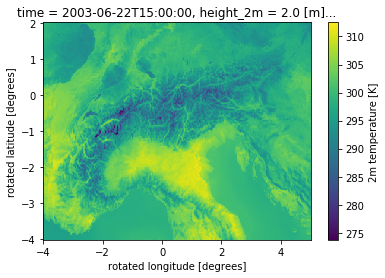

In [12]:
test_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

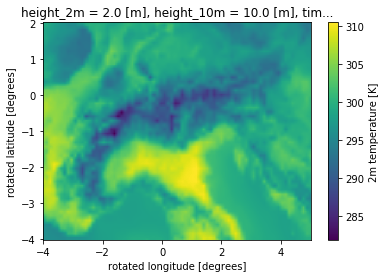

In [21]:
bil_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

Great it works